In [277]:
import pandas as pd
import numpy as np
import datetime

In [312]:
btc = pd.read_excel('../data/pricing_data.xlsx', sheet_name='BTCUSD')

# Convert the 'Date' column to datetime format
btc['Date'] = pd.to_datetime(btc['Date'])

# Sort by date
btc = btc.sort_values(by='Date')

# Reset index if needed
btc.reset_index(drop=True, inplace=True)

In [279]:
def calculate_bollinger_bands(df, window=20, num_std=2):
    """Calculate Bollinger Bands for the given data"""
    # Calculate middle band (SMA20)
    df['BB_middle'] = df['Close'].rolling(window=window).mean()
    
    # Calculate standard deviation
    rolling_std = df['Close'].rolling(window=window).std()
    
    # Calculate upper and lower bands
    df['BB_upper'] = df['BB_middle'] + (rolling_std * num_std)
    df['BB_lower'] = df['BB_middle'] - (rolling_std * num_std)
    
    # Calculate bandwidth and %B
    df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']
    df['BB_pctB'] = (df['Close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])
    
    return df

In [298]:
def calculate_rsi(df):
    df['PriceChange'] = df['Close'].diff()

    df['Gain'] = df['PriceChange'].where(df['PriceChange'] > 0, 0)
    df['Loss'] = df['PriceChange'].where(df['PriceChange'] < 0, 0)

    window = 10
    df['AvgGain'] = df['Gain'].rolling(window=window, min_periods=1).mean()
    df['AvgLoss'] = df['Loss'].rolling(window=window, min_periods=1).mean()

    df['RS'] = df['AvgGain']/df['AvgLoss']

    df['RSI'] = 100 -(100 / (1+df['RS']))

    df.loc[df.index[:12], 'RSI'] = np.nan

    return df

In [280]:
def calculate_macd(df):
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_histogram'] = df['MACD'] - df['MACD_signal']

    return df

In [305]:
def generate_enhanced_signals(df):
    """Generate trading signals using SMA crossovers and Bollinger Bands"""
    # Calculate basic SMA signals (as before)
    #bullish_sma = (df['SMAVG (5)  on Close'] > df['SMAVG (10)  on Close']) & (df['SMAVG (10)  on Close'] > df['SMAVG (15)  on Close'])
    #bearish_sma = (df['SMAVG (5)  on Close'] < df['SMAVG (10)  on Close']) & (df['SMAVG (10)  on Close'] < df['SMAVG (15)  on Close'])
    bullish_sma = (df['Close'].rolling(50).mean() > df['Close'].rolling(200).mean())# & (df['Close'].rolling(10).mean() > df['Close'].rolling(50).mean())
    bearish_sma = (df['Close'].rolling(50).mean() < df['Close'].rolling(200).mean())# & (df['Close'].rolling(10).mean() < df['Close'].rolling(50).mean())
    sma_signal = np.where(bullish_sma, 1, np.where(bearish_sma, -1, 0))

    df = calculate_macd(df.copy())

    bullish_macd = df['MACD_histogram'] > 40
    bearish_macd = df['MACD_histogram'] < -40
    macd_signal = np.where(bullish_macd, 1, np.where(bearish_macd, -1, 0))

    
    # Calculate Bollinger Band signals
    # Oversold: Close price below lower band (potential buy)
    # Overbought: Close price above upper band (potential sell)
    bb_oversold = df['Close'] < df['BB_lower']
    bb_overbought = df['Close'] > df['BB_upper']
    
    # Mean reversion potential when price is near bands
    bb_signal = np.where(bb_oversold, 1, np.where(bb_overbought, -1, 0))
    
    # Bollinger Band squeeze (contraction) indicates potential breakout
    bb_squeeze = df['BB_width'] < df['BB_width'].rolling(window=50).mean() * 0.85
    
    # Combined signal (weighted approach)
    # SMA trend signals get 60% weight, BB signals get 40% weight
    combined_signal = (macd_signal * 0.25) + (bb_signal * 0.5) + (sma_signal * 0.25)
    
    return pd.DataFrame({
        'macd_signal': sma_signal,
        'bb_signal': bb_signal,
        'combined_signal': combined_signal,
        'bb_squeeze': bb_squeeze,
        'price': df['Close'],
        'pctB': df['BB_pctB']
    }, index=df.index)


In [319]:
import pandas as pd
import numpy as np

# Initial investment and parameters
initial_investment = 200000
stop_loss_pct = 0.05  # 5% stop loss
commission_rate = 0.0005
btc_val = btc[(btc['Date'] >= datetime.datetime(2025, 1, 1)) & (btc['Date'] < datetime.datetime(2025, 3, 1))]
trading_results2 = calculate_bollinger_bands(btc_val.copy(), window=30).copy().reset_index(drop=True)

# Create trading signals
trading_results2['Signal'] = 0

# Initialize portfolio columns
trading_results2['Position'] = 0
trading_results2['Cash'] = initial_investment
trading_results2['Entry_Price'] = 0
trading_results2['Portfolio_Value'] = initial_investment
trading_results2['Trade_Action'] = 'Hold'

# Initialize variables
position = 0
entry_price = 0
cash = initial_investment
total_commission = 0
entry_price = None

for i in range(1, len(trading_results2)):
    prev_close = trading_results2.at[i-1, 'Close']
    current_open = trading_results2.at[i, 'Open']
    #prev_ma200 = trading_results2.at[i-1, 'MA200_lag1']
    #prev_ma20 = trading_results2.at[i-1, 'MA20_lag1']
    #prev_ma50 = trading_results2.at[i-1, 'MA50_lag1']
    lowerbb = trading_results2.at[i, 'BB_lower']
    upperbb = trading_results2.at[i, 'BB_upper']
    #prev_rsi = trading_results2.at[i, 'RSI_lag1']

    trading_results2.at[i, 'Signal'] = generate_enhanced_signals(trading_results2.iloc[:i-1])['combined_signal'].iloc[-1]

    current_price = trading_results2['Close'].iloc[i]
    current_signal = trading_results2['Signal'].iloc[i]
    #print(current_signal)

    if position > 0 and current_price < entry_price * (1 - stop_loss_pct):
        current_signal = -1  # Force sell

    # Trading logic
    if current_signal > 0.5 and cash > 16000:  # Buy
        buy_amount = cash-16000
        buy_units = buy_amount / current_price
        commission = buy_amount * commission_rate
        total_commission += commission
        
        if position == 0:
            entry_price = current_price
            trading_results2.at[i, 'Trade_Action'] = 'Buy'
        else:
            trading_results2.at[i, 'Trade_Action'] = 'Add Long'
            entry_price = (entry_price * position + current_price * buy_units) / (position + buy_units)  # Adjust entry price
        
        position += buy_units
        cash -= (buy_amount + commission)

    elif current_signal < -0.5 and position > 0:  # Sell
        sell_amount = position * current_price
        commission = sell_amount * commission_rate
        total_commission += commission

        cash += sell_amount - commission
        position = 0
        entry_price = 0
        trading_results2.at[i, 'Trade_Action'] = 'Sell'

    # Update Portfolio Value
    portfolio_value = cash + position * current_price
    trading_results2.at[i, 'Position'] = position
    trading_results2.at[i, 'Cash'] = cash
    trading_results2.at[i, 'Entry_Price'] = entry_price
    trading_results2.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate performance metrics
total_return = (trading_results2['Portfolio_Value'].iloc[-1] / initial_investment - 1) * 100
num_trades = len(trading_results2[trading_results2['Trade_Action'] != 'Hold'])
max_drawdown = (trading_results2['Portfolio_Value'].cummax() - trading_results2['Portfolio_Value']) / trading_results2['Portfolio_Value'].cummax()

print(f"Total Return: {total_return:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown.max()*100:.2f}%")
print(f"Final Portfolio Value: {trading_results2['Portfolio_Value'].iloc[-1]:,.2f}")

IndexError: single positional indexer is out-of-bounds

In [283]:
import pandas as pd
import numpy as np

# Initial investment and parameters
initial_investment = 200000
stop_loss_pct = 0.05  # 5% stop loss
commission_rate = 0.0005
btc_val = btc[(btc['Date'] >= datetime.datetime(2025, 3, 1)) & (btc['Date'] < datetime.datetime(2025, 3, 30))]
trading_results2 = calculate_bollinger_bands(btc_val.copy(), window=30).copy().reset_index(drop=True)

# Create trading signals
trading_results2['Signal'] = 0

# Initialize portfolio columns
trading_results2['Position'] = 0
trading_results2['Cash'] = initial_investment
trading_results2['Entry_Price'] = 0
trading_results2['Portfolio_Value'] = initial_investment
trading_results2['Trade_Action'] = 'Hold'

# Initialize variables
position = 0
entry_price = 0
cash = initial_investment
total_commission = 0
entry_price = None

for i in range(1, len(trading_results2)):
    prev_close = trading_results2.at[i-1, 'Close']
    current_open = trading_results2.at[i, 'Open']
    #prev_ma200 = trading_results2.at[i-1, 'MA200_lag1']
    #prev_ma20 = trading_results2.at[i-1, 'MA20_lag1']
    #prev_ma50 = trading_results2.at[i-1, 'MA50_lag1']
    lowerbb = trading_results2.at[i, 'BB_lower']
    upperbb = trading_results2.at[i, 'BB_upper']
    #prev_rsi = trading_results2.at[i, 'RSI_lag1']

    trading_results2.at[i, 'Signal'] = generate_enhanced_signals_spy(trading_results2.iloc[i-1])['combined_signal'].iloc[-1]

    current_price = trading_results2['Close'].iloc[i]
    current_signal = trading_results2['Signal'].iloc[i]
    #print(current_signal)

    if position > 0 and current_price < entry_price * (1 - stop_loss_pct):
        current_signal = -1  # Force sell

    # Trading logic
    if current_signal > 0.5 and cash > 16000:  # Buy
        buy_amount = cash-16000
        buy_units = buy_amount / current_price
        commission = buy_amount * commission_rate
        total_commission += commission
        
        if position == 0:
            entry_price = current_price
            trading_results2.at[i, 'Trade_Action'] = 'Buy'
        else:
            trading_results2.at[i, 'Trade_Action'] = 'Add Long'
            entry_price = (entry_price * position + current_price * buy_units) / (position + buy_units)  # Adjust entry price
        
        position += buy_units
        cash -= (buy_amount + commission)

    elif current_signal < -0.5 and position > 0:  # Sell
        sell_amount = position * current_price
        commission = sell_amount * commission_rate
        total_commission += commission

        cash += sell_amount - commission
        position = 0
        entry_price = 0
        trading_results2.at[i, 'Trade_Action'] = 'Sell'

    # Update Portfolio Value
    portfolio_value = cash + position * current_price
    trading_results2.at[i, 'Position'] = position
    trading_results2.at[i, 'Cash'] = cash
    trading_results2.at[i, 'Entry_Price'] = entry_price
    trading_results2.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate performance metrics
total_return = (trading_results2['Portfolio_Value'].iloc[-1] / initial_investment - 1) * 100
num_trades = len(trading_results2[trading_results2['Trade_Action'] != 'Hold'])
max_drawdown = (trading_results2['Portfolio_Value'].cummax() - trading_results2['Portfolio_Value']) / trading_results2['Portfolio_Value'].cummax()

print(f"Total Return: {total_return:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown.max()*100:.2f}%")
print(f"Final Portfolio Value: {trading_results2['Portfolio_Value'].iloc[-1]:,.2f}")

C:\Users\kaili\AppData\Local\Temp\ipykernel_33516\1421945172.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results2.at[i, 'Signal'] = generate_enhanced_signals_spy(trading_results2.iloc[i-1])['combined_signal'].iloc[-1]
C:\Users\kaili\AppData\Local\Temp\ipykernel_33516\1421945172.py:76: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.0212166230127817' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results2.at[i, 'Position'] = position
C:\Users\kaili\AppData\Local\Temp\ipykernel_33516\1421945172.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '197777.415345516' has dtype incompatibl

Total Return: -7.25%
Number of Trades: 7
Maximum Drawdown: 13.66%
Final Portfolio Value: 185,493.17


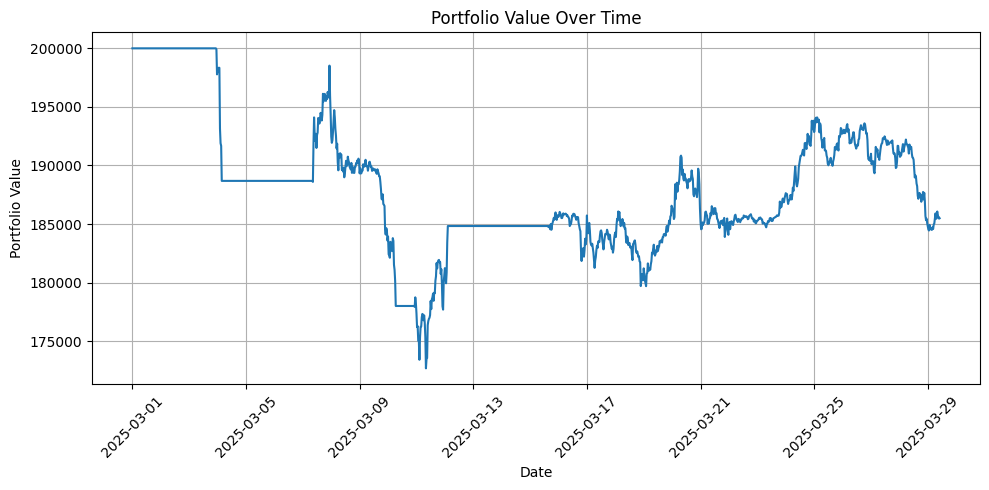

In [284]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(trading_results2['Date'], trading_results2['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout
plt.show()

### SPY Strategy

In [311]:
spy = pd.read_excel('../data/pricing_data.xlsx', sheet_name='SPY')

# Convert the 'Date' column to datetime format
spy['Date'] = pd.to_datetime(spy['Date'])

# Sort by date
spy = spy.sort_values(by='Date')

# Reset index if needed
spy.reset_index(drop=True, inplace=True)

In [286]:
import pandas as pd
import numpy as np

# Initial investment and settings
initial_investment = 800000
commission_rate = 0.0003
stop_loss_pct = 0.05  # 5% stop loss
spy_val = spy[(spy['Date'] >= datetime.datetime(2025, 1, 1)) & (spy['Date'] < datetime.datetime(2025, 3, 1))]
trading_results3 = calculate_bollinger_bands(spy_val.copy(), window=30).copy().reset_index(drop=True)
initial_spy_price = trading_results3['Close'].iloc[0]

# Initial allocations
cash = initial_investment
position = 0  # SPY units
total_commission = 0
entry_price = None  # Track entry price for stop-loss

# Buy-and-hold benchmark
buy_and_hold_units = int(initial_investment / initial_spy_price)
buy_and_hold_final_value = buy_and_hold_units * trading_results3['Close'].iloc[-1]
buy_and_hold_return_pct = (buy_and_hold_final_value / initial_investment - 1) * 100


# Create trading signals
trading_results3['Signal'] = 0

# Initialize tracking columns
trading_results3['Position'] = 0
trading_results3['Cash'] = cash
trading_results3['Portfolio_Value'] = initial_investment
trading_results3['Trade_Action'] = 'Hold'
trading_results3['Vol_Mean'] = trading_results3['Volume'].shift(1).rolling(20).mean()

for i in range(len(trading_results3)):
    current_price = trading_results3['Close'].iloc[i]
    current_open = trading_results3['Open'].iloc[i]
    #prev_ma20 = trading_results3['MA20_lag1'].iloc[i]
    #prev_ma50 = trading_results3['MA50_lag1'].iloc[i]
    #upperbb = trading_results3['BB_Upper_lag1'].iloc[i]
    #lowerbb = trading_results3['BB_Lower_lag1'].iloc[i]
    vol_mean = trading_results3['Vol_Mean'].iloc[i]

    # Generate trading signals
    trading_results3.at[i, 'Signal'] = generate_enhanced_signals_spy(trading_results3.iloc[i-1])['combined_signal'].iloc[-1]

    current_signal = trading_results3['Signal'].iloc[i]

    # **Stop-loss condition**
    if position > 0 and current_price < entry_price * (1 - stop_loss_pct):
        current_signal = -1  # Force sell

    # **Trading logic - no short selling allowed**
    if current_signal > 0.5 and cash > 8000:  # Buy signal
        max_buy_units = cash / (current_price * (1 + commission_rate))  # Adjust for commission
        if max_buy_units > 0:
            buy_units = max_buy_units
            commission = buy_units * current_price * commission_rate
            cash -= (buy_units * current_price + commission)
            total_commission += commission
            position += buy_units
            entry_price = current_price  # Record entry price for stop-loss
            trading_results3.at[i, 'Trade_Action'] = 'Buy' if position == buy_units else 'Add Long'

    elif current_signal < -0.5 and position > 0:  # Sell signal
        sell_amount = position * current_price
        commission = sell_amount * commission_rate
        total_commission += commission
        cash += sell_amount - commission
        position = 0  # Close position
        trading_results3.at[i, 'Trade_Action'] = 'Sell'

    # Update tracking columns
    portfolio_value = cash + position * current_price
    trading_results3.at[i, 'Position'] = position
    trading_results3.at[i, 'Cash'] = cash
    trading_results3.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate performance metrics
total_return_pct = (trading_results3['Portfolio_Value'].iloc[-1] / initial_investment - 1) * 100
num_trades = len(trading_results3[trading_results3['Trade_Action'] != 'Hold'])
max_drawdown_pct = ((trading_results3['Portfolio_Value'].cummax() - trading_results3['Portfolio_Value']) / trading_results3['Portfolio_Value'].cummax()).max() * 100

# Print final stats
print(f"Total Return: {total_return_pct:.2f}%")
print(f"Buy-and-Hold Return: {buy_and_hold_return_pct:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown_pct:.2f}%")
print(f"Final Portfolio Value: {trading_results3['Portfolio_Value'].iloc[-1]:,.2f}")
print(f"Final Cash: {trading_results3['Cash'].iloc[-1]:,.2f}")
print(f"Final Position: {trading_results3['Position'].iloc[-1]}")
print(f"Total Commission Paid: {total_commission:,.2f}")

Total Return: 1.68%
Buy-and-Hold Return: 0.33%
Number of Trades: 3
Maximum Drawdown: 4.15%
Final Portfolio Value: 813,431.83
Final Cash: -0.00
Final Position: 1381.3201908665355
Total Commission Paid: 744.21


C:\Users\kaili\AppData\Local\Temp\ipykernel_33516\1559152853.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Signal'] = generate_enhanced_signals_spy(trading_results3.iloc[i-1])['combined_signal'].iloc[-1]
C:\Users\kaili\AppData\Local\Temp\ipykernel_33516\1559152853.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1374.3990733400124' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Position'] = position
C:\Users\kaili\AppData\Local\Temp\ipykernel_33516\1559152853.py:76: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '799760.0719784065' has dtype incompati

In [287]:
import pandas as pd
import numpy as np

# Initial investment and settings
initial_investment = 800000
commission_rate = 0.0003
stop_loss_pct = 0.05  # 5% stop loss
spy_val = spy[(spy['Date'] >= datetime.datetime(2025, 3, 1)) & (spy['Date'] < datetime.datetime(2025, 3, 30))]
trading_results4 = calculate_bollinger_bands(spy_val.copy(), window=30).copy().reset_index(drop=True)
initial_spy_price = trading_results4['Close'].iloc[0]

# Initial allocations
cash = initial_investment
position = 0  # SPY units
total_commission = 0
entry_price = None  # Track entry price for stop-loss

# Buy-and-hold benchmark
buy_and_hold_units = int(initial_investment / initial_spy_price)
buy_and_hold_final_value = buy_and_hold_units * trading_results4['Close'].iloc[-1]
buy_and_hold_return_pct = (buy_and_hold_final_value / initial_investment - 1) * 100


# Create trading signals
trading_results4['Signal'] = 0

# Initialize tracking columns
trading_results4['Position'] = 0
trading_results4['Cash'] = cash
trading_results4['Portfolio_Value'] = initial_investment
trading_results4['Trade_Action'] = 'Hold'
trading_results4['Vol_Mean'] = trading_results4['Volume'].shift(1).rolling(20).mean()

for i in range(len(trading_results4)):
    current_price = trading_results4['Close'].iloc[i]
    current_open = trading_results4['Open'].iloc[i]
    #prev_ma20 = trading_results3['MA20_lag1'].iloc[i]
    #prev_ma50 = trading_results3['MA50_lag1'].iloc[i]
    #upperbb = trading_results3['BB_Upper_lag1'].iloc[i]
    #lowerbb = trading_results3['BB_Lower_lag1'].iloc[i]
    vol_mean = trading_results4['Vol_Mean'].iloc[i]

    # Generate trading signals
    trading_results4.at[i, 'Signal'] = generate_enhanced_signals_spy(trading_results4.iloc[i-1])['combined_signal'].iloc[-1]

    current_signal = trading_results4['Signal'].iloc[i]

    # **Stop-loss condition**
    if position > 0 and current_price < entry_price * (1 - stop_loss_pct):
        current_signal = -1  # Force sell

    # **Trading logic - no short selling allowed**
    if current_signal >= 0.5 and cash > 8000:  # Buy signal
        max_buy_units = cash / (current_price * (1 + commission_rate))  # Adjust for commission
        if max_buy_units > 0:
            buy_units = max_buy_units
            commission = buy_units * current_price * commission_rate
            cash -= (buy_units * current_price + commission)
            total_commission += commission
            position += buy_units
            entry_price = current_price  # Record entry price for stop-loss
            trading_results4.at[i, 'Trade_Action'] = 'Buy' if position == buy_units else 'Add Long'

    elif current_signal <= -0.5 and position > 0:  # Sell signal
        sell_amount = position * current_price
        commission = sell_amount * commission_rate
        total_commission += commission
        cash += sell_amount - commission
        position = 0  # Close position
        trading_results4.at[i, 'Trade_Action'] = 'Sell'

    # Update tracking columns
    portfolio_value = cash + position * current_price
    trading_results4.at[i, 'Position'] = position
    trading_results4.at[i, 'Cash'] = cash
    trading_results4.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate performance metrics
total_return_pct = (trading_results4['Portfolio_Value'].iloc[-1] / initial_investment - 1) * 100
num_trades = len(trading_results4[trading_results4['Trade_Action'] != 'Hold'])
max_drawdown_pct = ((trading_results4['Portfolio_Value'].cummax() - trading_results4['Portfolio_Value']) / trading_results4['Portfolio_Value'].cummax()).max() * 100

# Print final stats
print(f"Total Return: {total_return_pct:.2f}%")
print(f"Buy-and-Hold Return: {buy_and_hold_return_pct:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown_pct:.2f}%")
print(f"Final Portfolio Value: {trading_results4['Portfolio_Value'].iloc[-1]:,.2f}")
print(f"Final Cash: {trading_results4['Cash'].iloc[-1]:,.2f}")
print(f"Final Position: {trading_results4['Position'].iloc[-1]}")
print(f"Total Commission Paid: {total_commission:,.2f}")

Total Return: -1.68%
Buy-and-Hold Return: -5.18%
Number of Trades: 1
Maximum Drawdown: 3.57%
Final Portfolio Value: 786,540.90
Final Cash: 0.00
Final Position: 1415.3292016536118
Total Commission Paid: 239.93


C:\Users\kaili\AppData\Local\Temp\ipykernel_33516\2766355666.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results4.at[i, 'Signal'] = generate_enhanced_signals_spy(trading_results4.iloc[i-1])['combined_signal'].iloc[-1]
C:\Users\kaili\AppData\Local\Temp\ipykernel_33516\2766355666.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1415.3292016536118' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results4.at[i, 'Position'] = position
C:\Users\kaili\AppData\Local\Temp\ipykernel_33516\2766355666.py:76: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '799760.0719784065' has dtype incompati

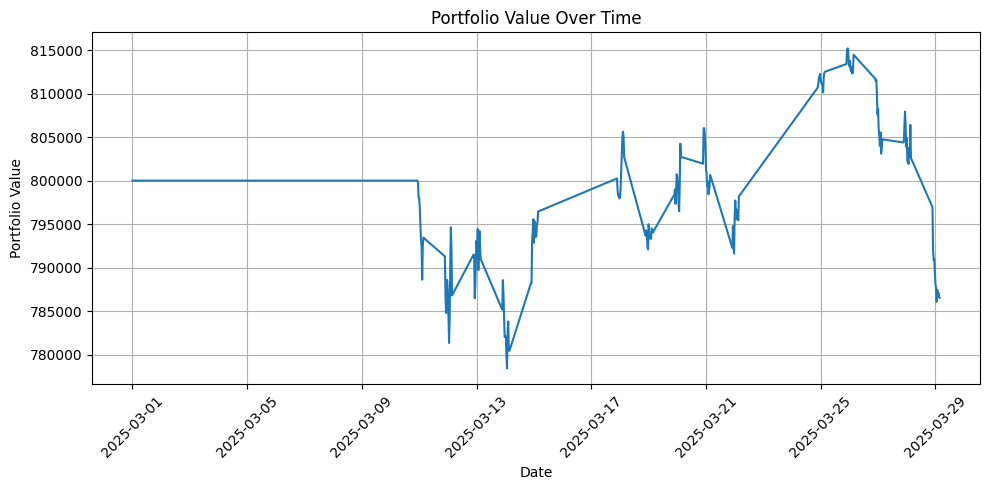

In [288]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(trading_results4['Date'], trading_results4['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout
plt.show()

In [289]:
buy_and_hold_final_value

758571.4500000001

In [293]:
trading_results

,Date,Open_BTC,High_BTC,Low_BTC,Close_BTC,SMAVG (5) on Close_BTC,SMAVG (10) on Close_BTC,SMAVG (15) on Close_BTC,Open_SPY,High_SPY,...,SMAVG (10) on Close_SPY,SMAVG (15) on Close_SPY,Volume,Vol_Mean,Cash,Position_SPY,Position_BTC,Portfolio_Value,Trade_Action_SPY,Trade_Action_BTC
0,2025-03-01 00:00:00,84020.59,84090.72,83503.11,83619.56,83159.48,81932.94,81360.57,588.89,589.03,...,588.898,590.430,1940335.0,NaN,1000000,0,0,1000000,Hold,Hold
1,2025-03-01 00:30:00,83618.61,84909.19,83599.62,84368.27,83675.94,82322.25,81628.57,585.90,588.34,...,588.174,590.025,1421764.0,NaN,1000000,0,0,1000000,Hold,Hold
2,2025-03-01 01:00:00,84368.27,84383.75,83865.06,84192.30,84103.55,82726.16,81888.73,587.34,588.30,...,587.507,589.556,1229612.0,NaN,1000000,0,0,1000000,Hold,Hold
3,2025-03-01 01:30:00,84193.27,84282.23,83585.55,83600.77,83960.30,83011.91,82135.72,587.16,587.18,...,586.781,588.955,3094521.0,NaN,1000000,0,0,1000000,Hold,Hold
4,2025-03-01 02:00:00,83600.77,84103.61,83194.08,83808.28,83917.84,83323.21,82390.91,583.47,584.79,...,586.331,588.334,5195384.0,NaN,1000000,0,0,1000000,Hold,Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,2025-03-29 08:00:00,84383.89,84526.28,84333.08,84507.50,84343.40,84100.96,83998.30,NaN,NaN,...,NaN,NaN,NaN,NaN,1000000,0,0,1000000,Hold,Hold
1360,2025-03-29 08:30:00,84507.44,84574.97,84328.86,84359.25,84375.02,84163.83,84042.17,NaN,NaN,...,NaN,NaN,NaN,NaN,1000000,0,0,1000000,Hold,Hold
1361,2025-03-29 09:00:00,84359.25,84465.81,84192.02,84212.67,84332.20,84201.45,84060.29,NaN,NaN,...,NaN,NaN,NaN,NaN,1000000,0,0,1000000,Hold,Hold
1362,2025-03-29 09:30:00,84212.67,84379.19,84184.97,84258.75,84344.41,84250.80,84092.69,NaN,NaN,...,NaN,NaN,NaN,NaN,1000000,0,0,1000000,Hold,Hold


In [317]:
import pandas as pd
import numpy as np

# Initial settings
initial_cash = 1000000  # Total starting cash for both assets
#initial_cash = 200000
commission_spy = 0.0003
commission_btc = 0.0005
stop_loss_pct_btc = 0.04  # 7% stop loss
stop_loss_pct_spy = 0.015  # 5% stop loss

# Copy merged dataset with both SPY and BTC data
#trading_results2 = calculate_bollinger_bands(btc_val.copy(), window=30).copy().reset_index(drop=True)
btc_m = calculate_bollinger_bands(btc.copy(), window=20).copy().reset_index(drop=True)
spy_m = calculate_bollinger_bands(spy.copy(), window=20).copy().reset_index(drop=True)
merged_combined = btc_m.merge(spy_m, how='left', on='Date', suffixes=['_BTC', '_SPY'])

#merged_combined_val = merged_combined[(merged_combined['Date'] >= datetime.datetime(2025, 1, 1)) & (merged_combined['Date'] < datetime.datetime(2025, 3, 1))]
#trading_results = merged_combined_val.copy().reset_index(drop=True)

merged_combined_test = merged_combined[(merged_combined['Date'] >= datetime.datetime(2025, 3, 1)) & (merged_combined['Date'] < datetime.datetime(2025, 3, 30))]
trading_results = merged_combined_test.copy().reset_index(drop=True)

trading_results['Vol_Mean'] = trading_results['Volume'].rolling(20).mean()
#trading_results['Predicted_Diff_BTC'] = trading_results['BTC_Predicted'] / trading_results['Open_BTC'] - 1
#trading_results['Predicted_Diff_SPY'] = trading_results['SPY_Predicted'] / trading_results['Open_SPY'] - 1

# Initialize portfolio variables
cash = initial_cash
position_spy = 0
position_btc = 0
entry_price_spy = None
entry_price_btc = None
total_commission = 0

# Add tracking columns
trading_results['Cash'] = cash
trading_results['Position_SPY'] = 0
trading_results['Position_BTC'] = 0
trading_results['Portfolio_Value'] = cash
trading_results['Trade_Action_SPY'] = 'Hold'
trading_results['Trade_Action_BTC'] = 'Hold'

# Initialize tracking variable for last known SPY price
prev_spy_price = None  
#trading_results['BB_Lower_lag1_SPY'] = trading_results['BB_Lower_lag1_SPY'].ffill()
#trading_results['BB_Upper_lag1_SPY'] = trading_results['BB_Upper_lag1_SPY'].ffill() # forward fill because need to access i-1 later on when necessary

for i in range(1, len(trading_results)):
    current_time = trading_results['Date'].iloc[i]
    
    # SPY data
    current_spy_price = trading_results['Close_SPY'].iloc[i]
    current_spy_open = trading_results['Open_SPY'].iloc[i]
    #lowerbb_spy = trading_results['BB_Lower_lag1_SPY'].iloc[i]
    #upperbb_spy = trading_results['BB_Upper_lag1_SPY'].iloc[i]
    prev_vol_spy = trading_results['Volume'].iloc[i-1]
    vol_mean_spy = trading_results['Vol_Mean'].iloc[i-1]
    #prev_lowerbb_spy = trading_results.at[i-1, 'BB_Lower_lag1_SPY']
    #prev_upperbb_spy = trading_results.at[i-1, 'BB_Upper_lag1_SPY']
    #volatility_spy = trading_results.at[i, 'STD15_lag1_SPY']

    # BTC data
    current_btc_price = trading_results['Close_BTC'].iloc[i]
    current_btc_open = trading_results['Open_BTC'].iloc[i]
    #lowerbb_btc = trading_results['BB_Lower_lag1_BTC'].iloc[i]
    #upperbb_btc = trading_results['BB_Upper_lag1_BTC'].iloc[i]
    #prev_ma50_btc = trading_results['MA50_lag1_BTC'].iloc[i]
    #prev_ma200_btc = trading_results['MA200_lag1_BTC'].iloc[i]
    #prev_ma10_btc = trading_results.at[i, 'SMAVG (10)  on Close_lag1_BTC']
    #prev_ma15_btc = trading_results.at[i, 'SMAVG (15)  on Close_lag1_BTC']

    # Generate trading signals for SPY (only during market hours)
    spy_signal = 0
    if not pd.isna(current_spy_price):  # Check if SPY is trading
        # Generate trading signals
        #if trading_results.at[i, 'Predicted_Diff_SPY'] > 0 and current_spy_open < lowerbb_spy * 1.0008 and ((lowerbb_spy - prev_lowerbb_spy) * (upperbb_spy - prev_upperbb_spy)) < 0 and volatility_spy < 4: 
        #    spy_signal = 1  # Buy signal
        #elif trading_results.at[i, 'Predicted_Diff_SPY'] < 0 and current_spy_open > upperbb_spy and prev_vol_spy > vol_mean_spy:
        #    spy_signal = -1  # Sell signal

        df_spy = calculate_bollinger_bands(spy.copy(), window=20)
        df_spy = df_spy[df_spy['Date'] <= current_time]
        #print(current_time)
        #print(df_spy.iloc[-1])
        spy_signal = generate_enhanced_signals(df_spy.iloc[:-1])['combined_signal'].iloc[-1]
        #print(spy_signal)
    # Generate trading signals for BTC
    btc_signal = 0
    #if trading_results.at[i, 'Predicted_Diff_BTC'] > 0.003 and current_btc_open <= lowerbb_btc and prev_ma50_btc > prev_ma200_btc and prev_ma10_btc < prev_ma15_btc: 
    #    btc_signal = 1
    #elif trading_results.at[i, 'Predicted_Diff_BTC'] < -0.0015 and current_btc_open >= upperbb_btc and prev_ma50_btc < prev_ma200_btc:
    #    btc_signal = -1

    df_btc = calculate_bollinger_bands(btc.copy(), window=20)
    df_btc = df_btc[df_btc['Date'] <= current_time]

    btc_signal = generate_enhanced_signals(df_btc.iloc[:-1])['combined_signal'].iloc[-1]
    #print(btc_signal)
    ### TRADING LOGIC ###
    
    # SPY Trading (Only during Market Hours)
    if spy_signal >= 0.4 and not pd.isna(current_spy_price) and cash > 10000:
        buy_amount = min(cash - 10000, cash * 0.87)  # Allocate max 50% cash to SPY
        buy_units = int(buy_amount / current_spy_price)
        commission = buy_units * current_spy_price * commission_spy
        if buy_units > 0:
            cash -= (buy_units * current_spy_price + commission)
            total_commission += commission
            position_spy += buy_units
            entry_price_spy = current_spy_price if position_spy == buy_units else entry_price_spy
            trading_results.at[i, 'Trade_Action_SPY'] = 'Buy'

    elif spy_signal <= -0.4 and position_spy > 0:  # Sell SPY
        sell_amount = position_spy * current_spy_price
        commission = sell_amount * commission_spy
        total_commission += commission
        cash += sell_amount - commission
        position_spy = 0
        entry_price_spy = None
        trading_results.at[i, 'Trade_Action_SPY'] = 'Sell'

    # BTC Trading (24/7)
    if btc_signal >= 0.4 and cash > 10000:
        buy_amount = min(cash - 10000, cash * 0.12)  # Allocate max 50% cash to BTC
        #buy_amount = cash - 10000
        buy_units = buy_amount / current_btc_price
        commission = buy_amount * commission_btc
        if buy_units > 0:
            cash -= (buy_amount + commission)
            total_commission += commission
            position_btc += buy_units
            entry_price_btc = current_btc_price if position_btc == buy_units else entry_price_btc
            trading_results.at[i, 'Trade_Action_BTC'] = 'Buy'

    elif btc_signal <= -0.4 and position_btc > 0:  # Sell BTC
        sell_amount = position_btc * current_btc_price
        commission = sell_amount * commission_btc
        total_commission += commission
        cash += sell_amount - commission
        position_btc = 0
        entry_price_btc = None
        trading_results.at[i, 'Trade_Action_BTC'] = 'Sell'

    # Stop-loss for SPY
    if position_spy > 0 and current_spy_price < entry_price_spy * (1 - stop_loss_pct_spy):
        sell_amount = position_spy * current_spy_price
        commission = sell_amount * commission_spy
        total_commission += commission
        cash += sell_amount - commission
        position_spy = 0
        entry_price_spy = None
        trading_results.at[i, 'Trade_Action_SPY'] = 'Stop-Loss Sell'

    # Stop-loss for BTC
    if position_btc > 0 and current_btc_price < entry_price_btc * (1 - stop_loss_pct_btc):
        sell_amount = position_btc * current_btc_price
        commission = sell_amount * commission_btc
        total_commission += commission
        cash += sell_amount - commission
        position_btc = 0
        entry_price_btc = None
        trading_results.at[i, 'Trade_Action_BTC'] = 'Stop-Loss Sell'

    # Carry forward previous SPY price if current price is NaN
    if pd.isna(current_spy_price) and prev_spy_price is not None:
        current_spy_price = prev_spy_price
    elif not pd.isna(current_spy_price):
        prev_spy_price = current_spy_price  # Update previous price if current price is valid

    # Update Portfolio Value
    portfolio_value = cash + (position_spy * current_spy_price if not pd.isna(current_spy_price) else 0) + (position_btc * current_btc_price)
    trading_results.at[i, 'Cash'] = cash
    trading_results.at[i, 'Position_SPY'] = position_spy
    trading_results.at[i, 'Position_BTC'] = position_btc
    trading_results.at[i, 'Portfolio_Value'] = portfolio_value

# Performance metrics
total_return = (trading_results['Portfolio_Value'].iloc[-1] / initial_cash - 1) * 100
num_trades = len(trading_results[(trading_results['Trade_Action_SPY'] != 'Hold') | (trading_results['Trade_Action_BTC'] != 'Hold')])
max_drawdown = ((trading_results['Portfolio_Value'].cummax() - trading_results['Portfolio_Value']) / trading_results['Portfolio_Value'].cummax()).max() * 100
returns = trading_results['Portfolio_Value'].pct_change().dropna()

# Print results
print(f"Total Return: {total_return:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print(f"Sharpe Ratio: {np.sqrt(252) * returns.mean() / returns.std()}")
print(f"Final Portfolio Value: {trading_results['Portfolio_Value'].iloc[-1]:,.2f}")
print(f"Final Cash: {trading_results['Cash'].iloc[-1]:,.2f}")
print(f"Final SPY Position: {trading_results['Position_SPY'].iloc[-1]}")
print(f"Final BTC Position: {trading_results['Position_BTC'].iloc[-1]}")
print(f"Total Commission Paid: {total_commission:,.2f}")

C:\Users\kaili\AppData\Local\Temp\ipykernel_33516\3301543590.py:175: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.394803242080656' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results.at[i, 'Position_BTC'] = position_btc
C:\Users\kaili\AppData\Local\Temp\ipykernel_33516\3301543590.py:173: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '774294.4036' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results.at[i, 'Cash'] = cash
C:\Users\kaili\AppData\Local\Temp\ipykernel_33516\3301543590.py:176: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '999730.8182604979' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


Total Return: -15.94%
Number of Trades: 191
Maximum Drawdown: 21.21%
Sharpe Ratio: -0.6487857255164804
Final Portfolio Value: 840,569.12
Final Cash: 10,308.50
Final SPY Position: 1494
Final BTC Position: 0.0
Total Commission Paid: 5,505.39


In [310]:
trading_results[trading_results['Trade_Action_BTC'] == 'Buy']

,Date,Open_BTC,High_BTC,Low_BTC,Close_BTC,SMAVG (5) on Close_BTC,SMAVG (10) on Close_BTC,SMAVG (15) on Close_BTC,Open_SPY,High_SPY,...,SMAVG (10) on Close_SPY,SMAVG (15) on Close_SPY,Volume,Vol_Mean,Cash,Position_SPY,Position_BTC,Portfolio_Value,Trade_Action_SPY,Trade_Action_BTC
35,2025-01-01 17:30:00,92963.72,93228.34,92826.16,93221.86,93234.64,93400.30,93470.05,NaN,NaN,...,NaN,NaN,NaN,NaN,879940.000000,0,1.287252,9.999400e+05,Hold,Buy
42,2025-01-01 21:00:00,93622.22,93713.22,93430.39,93558.48,93488.23,93324.98,93370.75,NaN,NaN,...,NaN,NaN,NaN,NaN,774294.403600,0,2.415881,1.000321e+06,Hold,Buy
76,2025-01-02 14:00:00,95421.70,95514.66,95236.61,95292.52,95363.02,95112.66,94967.24,NaN,NaN,...,NaN,NaN,NaN,NaN,880925.031662,0,1.260690,1.001059e+06,Hold,Buy
82,2025-01-02 17:00:00,95991.33,96313.83,95928.62,96253.48,95832.88,95640.57,95402.38,NaN,NaN,...,NaN,NaN,NaN,NaN,775161.172361,0,2.358946,1.002218e+06,Hold,Buy
86,2025-01-02 19:00:00,96607.95,96767.28,96383.62,96454.39,96507.52,96087.89,95846.27,NaN,NaN,...,NaN,NaN,NaN,NaN,682095.322007,0,3.323333,1.002645e+06,Hold,Buy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2167,2025-02-15 03:30:00,98228.19,98313.59,97720.28,97975.52,98264.25,97658.90,97370.59,610.130,610.302,...,610.101,609.848,699012.0,NaN,12542.525530,1553,0.037248,9.637859e+05,Hold,Buy
2168,2025-02-15 04:00:00,97975.52,98294.94,97867.44,98016.69,98154.43,97814.73,97460.77,610.140,610.245,...,610.042,609.939,835622.0,NaN,11036.669915,1553,0.052603,9.629791e+05,Hold,Buy
2169,2025-02-15 04:30:00,98016.77,98046.31,97062.00,97218.64,97934.05,97841.48,97504.33,609.652,610.290,...,609.956,609.997,5097232.0,NaN,9999.481665,1553,0.063267,9.630143e+05,Hold,Buy
2426,2025-02-20 13:00:00,97232.47,97233.66,97059.80,97061.08,97125.09,96997.68,96857.45,NaN,NaN,...,NaN,NaN,NaN,NaN,14159.965796,1553,0.019895,9.677073e+05,Hold,Buy


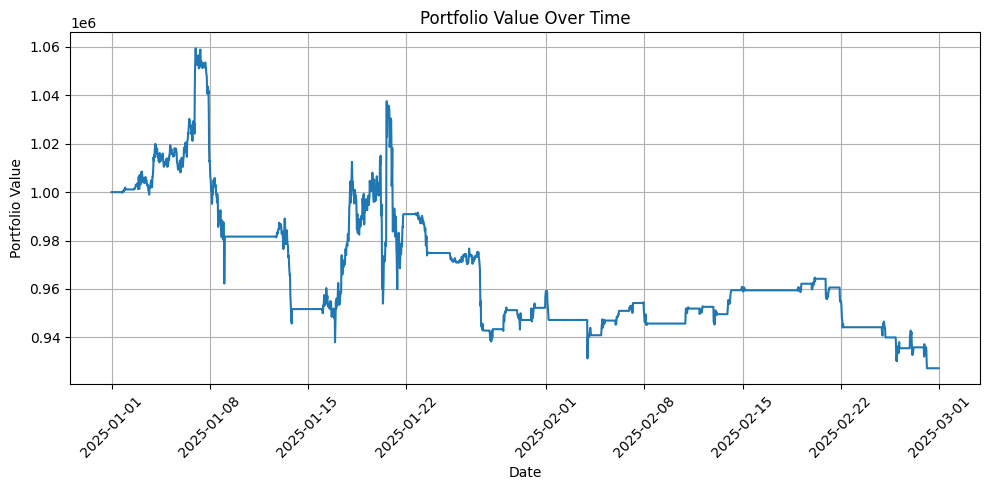

In [315]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(trading_results['Date'], trading_results['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout
plt.show()